In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score



In [3]:
# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/miftahudinfaiz/RainfallPrediction/main/Rainfall.csv')


In [4]:
# Preprocessing steps (drop columns, handle missing values, etc.)

# Drop irrelevant data
data = data.drop(columns=['Stasiun','Tanggal'], axis=1)
data = data.dropna(how='any')


In [5]:
# Split the data into features (X) and target variable (Y)
Y = data['Besok_hujan']
X = data.drop(columns=['Besok_hujan', 'Hari_hujan'])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=9)


In [6]:
# LinearSVC and Feature Selection
lsvc = LinearSVC(C=0.05, penalty="l1", dual=False, random_state=9).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
selected_features = list(X.columns[model.get_support(indices=True)])
X1 = data[selected_features]
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y, test_size=0.3, random_state=9)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [7]:
# PCA
pca = PCA().fit(X1)
X1_pca = pca.transform(X1)
variance = pd.Series(list(np.cumsum(pca.explained_variance_ratio_)), index=list(range(1, len(pca.explained_variance_ratio_) + 1)))


In [8]:
# Define the base classifier
base_classifier = KNeighborsClassifier(n_neighbors=5)


In [14]:
# Train the base classifier (KNN)
base_classifier.fit(X1_train, Y1_train)

KNeighborsClassifier()

In [9]:
# Define the ensemble bagging classifier
ensemble_model = BaggingClassifier(base_estimator=base_classifier, n_estimators=10, random_state=9)


In [10]:
# Train ensemble bagging model
ensemble_model.fit(X1_train, Y1_train)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=KNeighborsClassifier(), random_state=9)

In [15]:
# Predict using knn model
Y_pred_knn = base_classifier.predict(X1_test)
accuracy_knn = accuracy_score(Y1_test, Y_pred_knn)
confusion_matrix_knn = confusion_matrix(Y1_test, Y_pred_knn)
classification_report_knn = classification_report(Y1_test, Y_pred_knn)


In [16]:
# Evaluate knn model
print("knn Classification Report:")
print(classification_report_knn)
print("knn Accuracy:", accuracy_knn)
print("knn Confusion Matrix:")
print(confusion_matrix_knn)

knn Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       205
           1       0.79      1.00      0.88        72

    accuracy                           0.93       277
   macro avg       0.90      0.95      0.92       277
weighted avg       0.95      0.93      0.93       277

knn Accuracy: 0.9314079422382672
knn Confusion Matrix:
[[186  19]
 [  0  72]]


In [17]:
# Predict using ensemble bagging model
Y_pred_ensemble = ensemble_model.predict(X1_test)
accuracy_ensemble = accuracy_score(Y1_test, Y_pred_ensemble)
confusion_matrix_ensemble = confusion_matrix(Y1_test, Y_pred_ensemble)
classification_report_ensemble = classification_report(Y1_test, Y_pred_ensemble)


In [18]:
# Evaluate ensemble bagging model
print("Ensemble Bagging Classification Report:")
print(classification_report_ensemble)
print("Ensemble Bagging Accuracy:", accuracy_ensemble)
print("Ensemble Bagging Confusion Matrix:")
print(confusion_matrix_ensemble)



Ensemble Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       205
           1       0.79      0.99      0.88        72

    accuracy                           0.93       277
   macro avg       0.89      0.95      0.91       277
weighted avg       0.94      0.93      0.93       277

Ensemble Bagging Accuracy: 0.927797833935018
Ensemble Bagging Confusion Matrix:
[[186  19]
 [  1  71]]


In [19]:
# Average precision-recall score
average_precision = average_precision_score(Y1_test, Y_pred_ensemble)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))


Average precision-recall score: 0.78


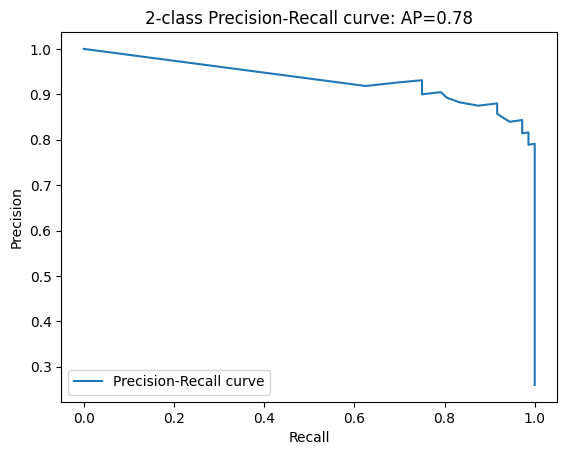

In [20]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(Y1_test, ensemble_model.predict_proba(X1_test)[:, 1])

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()


In [21]:
# Individual models evaluation
model_scores = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score'])


In [22]:
# KNN alone
train_score_knn = base_classifier.score(X1_train, Y1_train) * 100
test_score_knn = base_classifier.score(X1_test, Y1_test) * 100
model_scores = model_scores.append({'Model': 'KNN', 'Train Score': train_score_knn, 'Test Score': test_score_knn},
                                   ignore_index=True)


<ipython-input-22-f8b01aee63f2>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({'Model': 'KNN', 'Train Score': train_score_knn, 'Test Score': test_score_knn},


In [23]:
# Ensemble Bagging (KNN)
train_score_ensemble = ensemble_model.score(X1_train, Y1_train) * 100
test_score_ensemble = ensemble_model.score(X1_test, Y1_test) * 100
model_scores = model_scores.append({'Model': 'Ensemble Bagging', 'Train Score': train_score_ensemble,
                                    'Test Score': test_score_ensemble}, ignore_index=True)

print("\nModel Scores:")
print(model_scores)


Model Scores:
              Model  Train Score  Test Score
0               KNN    96.904025   93.140794
1  Ensemble Bagging    96.749226   92.779783


<ipython-input-23-1e7a7ca99fb2>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({'Model': 'Ensemble Bagging', 'Train Score': train_score_ensemble,
